# `DEPRESJON` - Exploring Gender Specific Machine Learning Models
## Model 3: Person level prediction using hourly data

>Garcia-Ceja, E., Riegler, M., Jakobsen, P., Tørresen, J., Nordgreen, T., Oedegaard, K.J. and Fasmer, O.B. (2018) Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In: Proceedings of the 9th ACM Multimedia Systems Conference [online]MMSys ’18: 9th ACM Multimedia Systems Conference. Amsterdam Netherlands: ACM, pp. 472–477. Available from: https://dl.acm.org/doi/10.1145/3204949.3208125 [Accessed 2 December 2023].

**Objectives**

* Recreate baseline models for Female/Male/All observations as done by (Garcia-Ceja et al., 2018)

**Files in Series**

* [wiki-08-base-1-eda](.\wiki-08-base-1-eda.ipynb)
* [wiki-08-base-2-person-days-rows](.\wiki-08-base-2-person-days-rows.ipynb)
* [wiki-08-base-3-person-prediction](.\wiki-08-base-3-person-prediction.ipynb)
* [wiki-08-base-4-person-hours.ipynb](.\wiki-08-base-4-person-hours.ipynb)



## Features

>"Each day was characterized by a feature vector which was computed by extracting a set of features **on a per day basis from the activity level**. The extracted features were the **mean activity level**, the corresponding **standard deviation** and the **percentage of events with no activity i.e, activity level = 0**. The features were **normalized between 0 and 1** before the classification." (Garcia-Ceja et al., 2018)

1. Create baseline features on "per day basis":

* `mean activity level`
* `standard deviation`
* `percentage of events with no activity`

2. Normalise features between 0 and 1



In [1]:
# import from csv
import pandas as pd
input_csv_path = '../data/petter/wiki-08-garcia.csv'
df = pd.read_csv(input_csv_path, parse_dates=['timestamp', 'date'])

In [2]:
# load functions in python file with magic command
%run ../code/wiki-08-base-functions.py

In [8]:
import pandas as pd

# group data by date and id (person and days) or just id (person)
grouped = df.groupby(['date', 'id', 'label', 'gender', 'hour_of_day'])


# features for each date-id combination - mean, std, and percentage of zeros
features = grouped['activity'].agg(['mean', 'std', lambda x: (x == 0).mean()])
features.columns = ['mean_activity', 'std_activity', 'pct_no_activity']

# reset index to make it a regular dataframe
features = features.reset_index()

# join with the original dataframe to get the labels
df_with_features = df.merge(features, on=['id','date', 'hour_of_day'], how='left')

# normalise the features between 0 and 1
df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']] = (
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']] - 
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].min()) / (
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].max() - 
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].min())

# drop unnecessary columns
#df_processed = df_with_features.drop(['timestamp', 'activity'], axis=1)
#df_processed = df_with_features.drop(['timestamp', 'activity', 'age', 'activity_norm', 'day_of_week'], axis=1)

# remove duplicate rows
features = features.drop_duplicates()

In [10]:
print(features.head())
print(features.info())

        date            id  label  gender  hour_of_day  mean_activity  \
0 2002-05-25  condition_20      1       1            0       0.000000   
1 2002-05-25  condition_20      1       1            1       0.916667   
2 2002-05-25  condition_20      1       1            2       0.233333   
3 2002-05-25  condition_20      1       1            3       2.716667   
4 2002-05-25  condition_20      1       1            4       8.916667   

   std_activity  pct_no_activity  
0      0.000000         1.000000  
1      5.340259         0.966667  
2      1.807392         0.983333  
3     21.043210         0.983333  
4     37.015476         0.916667  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16632 entries, 0 to 16631
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             16632 non-null  datetime64[ns]
 1   id               16632 non-null  object        
 2   label            16632 non

## Split datasets

1. Split by female/male/all
2. Split each into train/test

In [11]:
# create all, male, female dfs
both = features.copy()
male = features[features['gender'] == 2]
female = features[features['gender'] == 1]


In [12]:
# list of variable names to delete
var_list = ['grouped', 'features', 'df_with_features', 'df', 'df_processed']
# delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]

Split data into `test` and `train` sets, ensuring all rows for each person is in the same dataset.

In [13]:
# split each dataset into train and test sets
X_train_both, y_train_both, X_test_both, y_test_both, person_ids_train_both, person_ids_test_both = split_data_by_person(both)
X_train_male, y_train_male, X_test_male, y_test_male, person_ids_train_male, person_ids_test_male = split_data_by_person(male)
X_train_female, y_train_female, X_test_female, y_test_female, person_ids_train_female, person_ids_test_female = split_data_by_person(female)

In [14]:
# print info
print("Both data:")
print(f"Train set: {X_train_both.shape[0]} samples")
print(f"Test set: {X_test_both.shape[0]} samples")
print("\nMale data:")
print(f"Train set: {X_train_male.shape[0]} samples")
print(f"Test set: {X_test_male.shape[0]} samples")
print("\nFemale data:")
print(f"Train set: {X_train_female.shape[0]} samples")
print(f"Test set: {X_test_female.shape[0]} samples")

Both data:
Train set: 13200 samples
Test set: 3432 samples

Male data:
Train set: 5880 samples
Test set: 1560 samples

Female data:
Train set: 7632 samples
Test set: 1560 samples


## Model

* Single run for each `both`, `female` and `male`
* Each test/train dataset contains all rows from an `id`


In [18]:
models_list = [
    ('ZeroR', ZeroRClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVC', LinearSVC(dual=False, max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(max_iter=1000)),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier(verbose=-1)),
    ('AdaBoost', AdaBoostClassifier(algorithm='SAMME')),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier()), 
    ('SVM rbf', SVC(kernel='rbf')),
    ('SVM linear', SVC(kernel='linear')),
    ('Gaussian Process', GaussianProcessClassifier())
]

In [19]:
# update models to dictionary
models = {
    'Random Forest': RandomForestClassifier(),
    'Linear SVC': LinearSVC(dual=False, max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(force_col_wise=True, verbose=-1),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
    'QDA': QuadraticDiscriminantAnalysis(),
    'Gradient Boosting': GradientBoostingClassifier(), 
    'SVM rbf': SVC(kernel='rbf'),
    'SVM linear': SVC(kernel='linear'),
    'Gaussian Process': GaussianProcessClassifier()
}

## THIS TAKES 50 minutes to run

In [20]:
# empty dictionary to store results
all_results = {}

# single_run for each dataset
for dataset_name in ['both', 'male', 'female']:
    X_train = locals()[f"X_train_{dataset_name}"]
    X_test = locals()[f"X_test_{dataset_name}"]
    y_train = locals()[f"y_train_{dataset_name}"]
    y_test = locals()[f"y_test_{dataset_name}"]


    results = single_run(X_train, X_test, y_train, y_test, models_list, random_seed=5)

    # all_results with evaluation metrics (excluding predictions)
    all_results[dataset_name] = results



c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Use

In [21]:
# print metrics  needs 'all_results' dictionary
# options - (dataset, model, metric - can use 'all' for everything) -
print_model_metric(all_results, dataset = 'both', model = 'QDA')
print("\n")
print_model_metric(all_results, dataset = 'male', model = 'Gradient Boosting', metric='all')
print("\n")
print_model_metric(all_results, dataset = 'female', model = 'AdaBoost')

both dataset elapsed_time for QDA: 0.001718282699584961
both dataset accuracy for QDA: 0.5195221445221445
both dataset precision for QDA: 0.501699854298203
both dataset recall for QDA: 0.623792270531401
both dataset f1 for QDA: 0.5561238223418573
both dataset specificity for QDA: 0.4222972972972973
both dataset mcc for QDA: 0.04701006383118886
both dataset roc_auc for QDA: 0.5074990071593333


male dataset elapsed_time for Gradient Boosting: 0.5253632068634033
male dataset accuracy for Gradient Boosting: 0.5948717948717949
male dataset precision for Gradient Boosting: 0.6782608695652174
male dataset recall for Gradient Boosting: 0.65
male dataset f1 for Gradient Boosting: 0.6638297872340425
male dataset specificity for Gradient Boosting: 0.5066666666666667
male dataset mcc for Gradient Boosting: 0.15495441124800996
male dataset roc_auc for Gradient Boosting: 0.5849314236111111


female dataset elapsed_time for AdaBoost: 0.17793536186218262
female dataset accuracy for AdaBoost: 0.514743

In [27]:
# print best results for each dataset
for dataset_name, dataset_results in all_results.items():
    for metric in ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'mcc']:
        print_top_models(dataset_name, dataset_results, metric)
    print_top3_fastest_model(dataset_name, dataset_results)
    print("\n")


Top 3 models for both dataset based on accuracy:
1. Naive Bayes: 0.5591491841491841
2. Random Forest: 0.539044289044289
3. XGBoost: 0.5314685314685315

Top 3 models for both dataset based on precision:
1. Naive Bayes: 0.5359838953195772
2. Random Forest: 0.530278232405892
3. LightGBM: 0.52297165200391

Top 3 models for both dataset based on recall:
1. Naive Bayes: 0.6431159420289855
2. QDA: 0.623792270531401
3. Neural Network: 0.44565217391304346

Top 3 models for both dataset based on specificity:
1. ZeroR: 1.0
2. SVM linear: 0.8490990990990991
3. Linear SVC: 0.8440315315315315

Top 3 models for both dataset based on f1:
1. Naive Bayes: 0.5846829536096624
2. QDA: 0.5561238223418573
3. Neural Network: 0.47429305912596403

Top 3 models for both dataset based on mcc:
1. Naive Bayes: 0.12547051754634336
2. Random Forest: 0.07107325986181273
3. XGBoost: 0.054584249427533135

Top 3 fastest models (elapsed time) for both dataset:
1. ZeroR: 0.0009999275207519531
2. QDA: 0.001718282699584961


### Interpretation / Observations

**both** dataset
* Best models (`accuracy`) are `Naive Bayes`, `QDA` and `Neural network`
  * Compared to Model 2, the accuracy is much worse
  * This is expected because this model is predicting on a different row level - this is person day-hours, not person-days


## Confusion Matrix

**Confusion Matrices** are for "Person Days Hours" in the `Test Set`

But what about predicting whether a Person has depression, not whether a person's day appears to be from a depressed person?

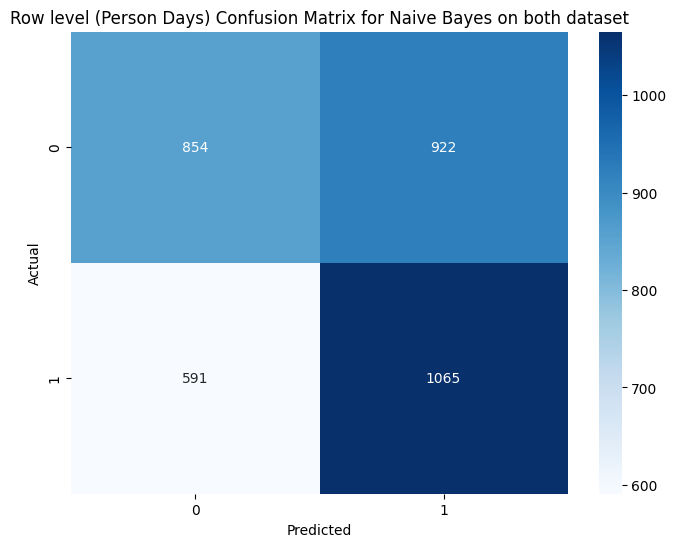

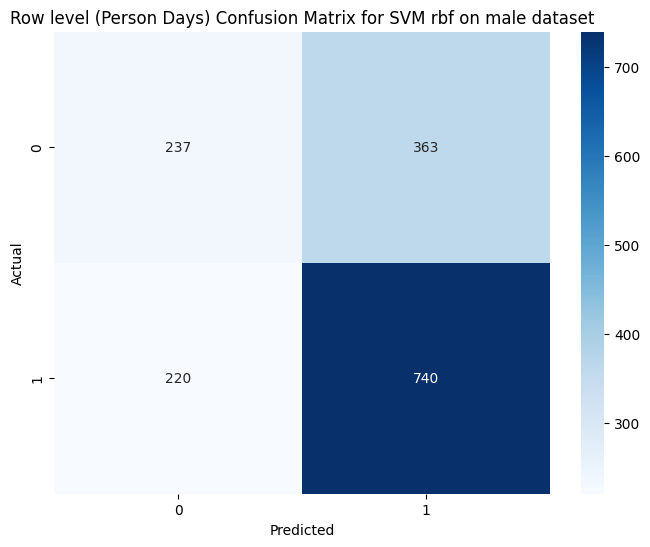

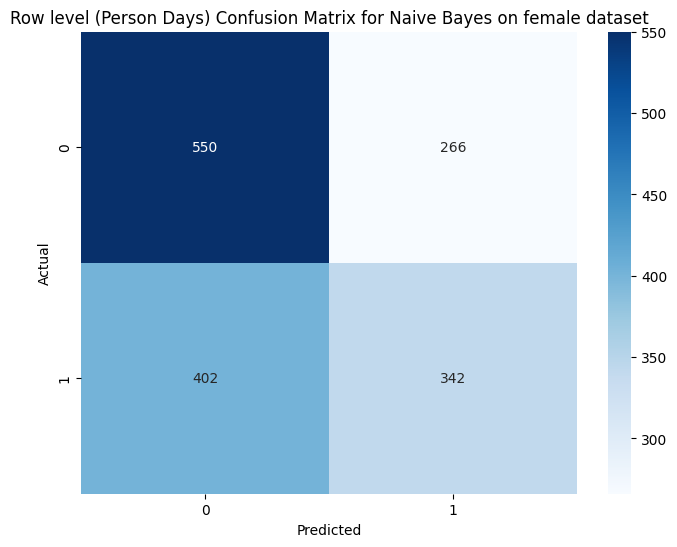

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

for dataset_name, dataset_results in all_results.items():
    # sort the models based on accuracy
    accuracy_sorted = sorted(dataset_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    
    # best performing model
    best_model_name, best_model_results = accuracy_sorted[0]
    
    # confusion matrix
    cm = best_model_results['cm']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title(f"Row level (Person Days) Confusion Matrix for {best_model_name} on {dataset_name} dataset")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [30]:
# prepare all, male, female into dictionary of X and y
datasets = {

    'male': {
        'X': both[both['gender'] == 2][['mean_activity', 'std_activity', 'pct_no_activity']].values,
        'y': both[both['gender'] == 2]['label'].values
    },
    'female': {
        'X': both[both['gender'] == 1][['mean_activity', 'std_activity', 'pct_no_activity']].values,
        'y': both[both['gender'] == 1]['label'].values
    }
}

# update models to dictionary
models = {
    #'ZeroR': ZeroRClassifier(),
    #'Random Forest': RandomForestClassifier(),
    #'Linear SVC': LinearSVC(dual=False, max_iter=10000),
    #'Decision Tree': DecisionTreeClassifier(),
    #'Logistic Regression': LogisticRegression(),
    #'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    #'Neural Network': MLPClassifier(max_iter=1000),
    #'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(force_col_wise=True, verbose=-1),
    #'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
    #'QDA': QuadraticDiscriminantAnalysis(),
    #'Gradient Boosting': GradientBoostingClassifier(), 
    #'SVM rbf': SVC(kernel='rbf'),
    #'SVM linear': SVC(kernel='linear'),
    #'Gaussian Process': GaussianProcessClassifier()
}

Best performing model on both: LightGBM
Confusion Matrix:
[[30  2]
 [18  5]]


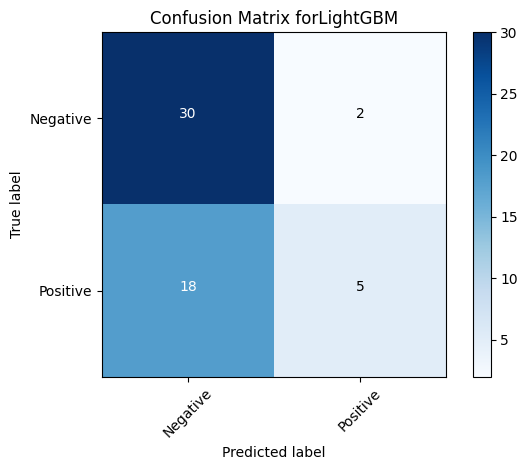

Best performing model on male: Naive Bayes
Confusion Matrix:
[[ 4  8]
 [ 1 12]]


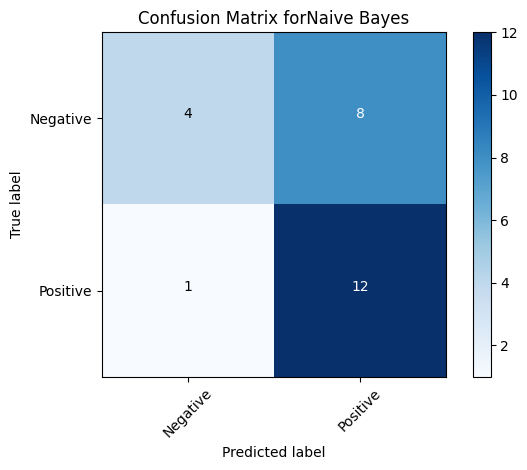

Best performing model on female: LightGBM
Confusion Matrix:
[[20  0]
 [ 9  1]]


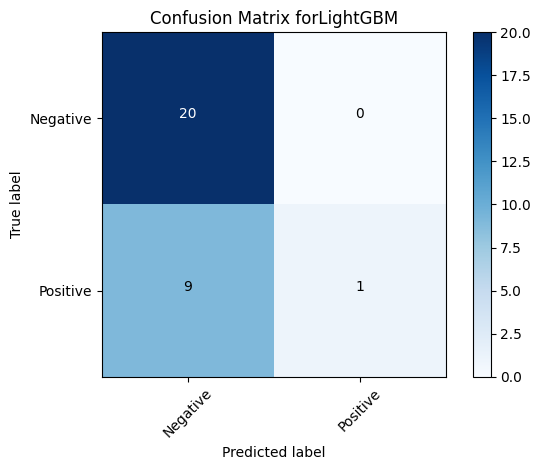

In [31]:
datasets = {
    'both': both,
    'male': male,
    'female': female
}

for name, data in datasets.items():
    # Check if 'label' column exists in the dataframe before proceeding
    if 'label' in data.columns:
        model, cm = fit_and_person_conf_matrix(data, models, metric='accuracy', aggregation_method='mode')
        print(f"Best performing model on {name}:", model)
        print("Confusion Matrix:")
        print(cm)
        plt.show()
    else:
        print(f"'label' column not found in {name} dataset. Please check your data.")


### Interpretation of Person prediction

The best models using hourly data and aggregating to get person level predictions are all worse than when predicting on person-day level data.

The `both` dataset has 20 incorrect classifications (18 False Negatives) in this model compared to 11 incorrect classifications in the best model using Person-Day level data. 

The `male` dataset's best model for Hour-level data has 9 incorrect classifications, same as with Day-level data, although 8 of 9 were False Positives, compared to a more even split with the Day-level data model.

The `female` dataset's best model for Hour-level data 9 misclassifications compared to 8 for the Day-level data.  However, the Hour-level data misclassifications were all False Negatives